In [1]:
import subprocess
from random import random, randint
from nfa_lib import NFA, random_matrix_for_nfa, count_nfa
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import seaborn as sns
from tqdm.auto import tqdm as tqdm
import pandas as pd
import pickle
from multiprocessing import Pool, TimeoutError
sns.set(rc={"figure.figsize": (14,10)})

In [2]:
def random_run():
    n_states = randint(2, 20)
    sparsity = round(random() / 2 + 0.5, 2)
    n_initial = randint(1, min(n_states, 5))
    n_final = randint(1, min(n_states, 5))
    string_length = randint(6, 20)
    rand_matrix = random_matrix_for_nfa(n_states=n_states, sparsity=sparsity, n_initial=n_initial, n_final=n_final)
    rand_nfa = NFA.from_random_matrix(rand_matrix)
    rand_nfa_text = rand_nfa.to_text()
    
    res_array = []
    
    epsilon = round(random() * 45 + 5, 1) # epsilon \in [5, 50]
    kappa_multiple = 1
    phi_multiple = round(2 ** (5 + random() * 5)) # phi_multiple \in [32, 1024]

    cpp_input = f"{string_length} {epsilon} {kappa_multiple} {phi_multiple}\n" + rand_nfa_text
    program = ["timeout", "90", "./cpp/main"]
    result = subprocess.run(program, 
                            stdout=subprocess.PIPE, 
                            input=cpp_input,
                            encoding="utf-8")
    res_dict = {}
    if result.returncode == 0:
        invalid = False
        for line in result.stdout.split("\n"):
            if "Got 0 when" in line or "Empty NFA" in line:
                invalid = True
                break
            l_split = line.split()
            if len(l_split) == 2:
                k, v = l_split
                res_dict[k] = float(v) if "." in v else int(v)
        if not invalid:
            res_dict["n_states"] = len(rand_nfa.states)
            res_dict["sparsity"] = sparsity
            res_dict["str_repr"] = cpp_input
            res_dict["string_len"] = string_length
            res_dict["epsilon"] = epsilon
            res_dict["kappa_multiple"] = kappa_multiple
            res_dict["phi_multiple"] = phi_multiple
            res_array.append(res_dict)


    return res_array

In [64]:
# results = []
samples = 0
errors = []
error_count = 0
n_proc = 6
with Pool(processes=n_proc) as pool:
    while error_count < 3:
        multiproc_results = [pool.apply_async(random_run) 
                             for i in range(6*n_proc)]
        for res_promise in tqdm(multiproc_results):
            res = None
            try:
                res = res_promise.get()
            except TimeoutError:
                continue

            if isinstance(res, Exception):
                errors.append(res)
                error_count += 1
                continue
            else:
                samples += 1
                if res:
                    results.extend(res)

        with open("cpp_random.pkl", "wb") as fd:
            pickle.dump(results, fd)
        print(f"Wrote pickle file for {len(results)} results")

100%|███████████████████████████████████████████| 36/36 [01:42<00:00,  2.85s/it]


Wrote pickle file for 680 results


100%|███████████████████████████████████████████| 36/36 [02:09<00:00,  3.58s/it]


Wrote pickle file for 703 results


100%|███████████████████████████████████████████| 36/36 [01:32<00:00,  2.56s/it]


Wrote pickle file for 732 results


100%|███████████████████████████████████████████| 36/36 [03:00<00:00,  5.00s/it]


Wrote pickle file for 756 results


100%|███████████████████████████████████████████| 36/36 [01:30<00:00,  2.52s/it]


Wrote pickle file for 780 results


100%|███████████████████████████████████████████| 36/36 [01:56<00:00,  3.23s/it]


Wrote pickle file for 811 results


100%|███████████████████████████████████████████| 36/36 [02:09<00:00,  3.60s/it]


Wrote pickle file for 837 results


100%|███████████████████████████████████████████| 36/36 [01:43<00:00,  2.88s/it]


Wrote pickle file for 862 results


100%|███████████████████████████████████████████| 36/36 [02:59<00:00,  4.98s/it]


Wrote pickle file for 890 results


100%|███████████████████████████████████████████| 36/36 [02:40<00:00,  4.45s/it]


Wrote pickle file for 917 results


100%|███████████████████████████████████████████| 36/36 [03:03<00:00,  5.10s/it]


Wrote pickle file for 942 results


100%|███████████████████████████████████████████| 36/36 [02:28<00:00,  4.13s/it]


Wrote pickle file for 969 results


100%|███████████████████████████████████████████| 36/36 [02:13<00:00,  3.70s/it]


Wrote pickle file for 997 results


100%|███████████████████████████████████████████| 36/36 [02:48<00:00,  4.68s/it]


Wrote pickle file for 1020 results


100%|███████████████████████████████████████████| 36/36 [01:02<00:00,  1.75s/it]


Wrote pickle file for 1049 results


100%|███████████████████████████████████████████| 36/36 [01:18<00:00,  2.17s/it]


Wrote pickle file for 1080 results


100%|███████████████████████████████████████████| 36/36 [02:24<00:00,  4.02s/it]


Wrote pickle file for 1105 results


100%|███████████████████████████████████████████| 36/36 [01:37<00:00,  2.72s/it]


Wrote pickle file for 1135 results


100%|███████████████████████████████████████████| 36/36 [01:38<00:00,  2.73s/it]


Wrote pickle file for 1159 results


100%|███████████████████████████████████████████| 36/36 [02:22<00:00,  3.95s/it]


Wrote pickle file for 1185 results


100%|███████████████████████████████████████████| 36/36 [02:32<00:00,  4.22s/it]


Wrote pickle file for 1208 results


100%|███████████████████████████████████████████| 36/36 [00:51<00:00,  1.43s/it]


Wrote pickle file for 1237 results


100%|███████████████████████████████████████████| 36/36 [01:47<00:00,  2.97s/it]


Wrote pickle file for 1260 results


100%|███████████████████████████████████████████| 36/36 [01:31<00:00,  2.53s/it]


Wrote pickle file for 1285 results


100%|███████████████████████████████████████████| 36/36 [01:50<00:00,  3.08s/it]


Wrote pickle file for 1315 results


100%|███████████████████████████████████████████| 36/36 [01:30<00:00,  2.50s/it]


Wrote pickle file for 1345 results


100%|███████████████████████████████████████████| 36/36 [01:33<00:00,  2.60s/it]


Wrote pickle file for 1373 results


100%|███████████████████████████████████████████| 36/36 [01:31<00:00,  2.53s/it]


Wrote pickle file for 1398 results


100%|███████████████████████████████████████████| 36/36 [02:10<00:00,  3.63s/it]


Wrote pickle file for 1425 results


100%|███████████████████████████████████████████| 36/36 [01:49<00:00,  3.05s/it]


Wrote pickle file for 1454 results


100%|███████████████████████████████████████████| 36/36 [01:17<00:00,  2.15s/it]


Wrote pickle file for 1483 results


100%|███████████████████████████████████████████| 36/36 [02:23<00:00,  3.98s/it]


Wrote pickle file for 1508 results


100%|███████████████████████████████████████████| 36/36 [01:51<00:00,  3.09s/it]


Wrote pickle file for 1534 results


100%|███████████████████████████████████████████| 36/36 [01:38<00:00,  2.74s/it]


Wrote pickle file for 1563 results


100%|███████████████████████████████████████████| 36/36 [01:37<00:00,  2.72s/it]


Wrote pickle file for 1593 results


100%|███████████████████████████████████████████| 36/36 [01:35<00:00,  2.65s/it]


Wrote pickle file for 1616 results


100%|███████████████████████████████████████████| 36/36 [02:09<00:00,  3.61s/it]


Wrote pickle file for 1643 results


100%|███████████████████████████████████████████| 36/36 [01:55<00:00,  3.20s/it]


Wrote pickle file for 1671 results


100%|███████████████████████████████████████████| 36/36 [02:19<00:00,  3.87s/it]


Wrote pickle file for 1699 results


100%|███████████████████████████████████████████| 36/36 [02:37<00:00,  4.37s/it]


Wrote pickle file for 1727 results


100%|███████████████████████████████████████████| 36/36 [02:56<00:00,  4.91s/it]


Wrote pickle file for 1754 results


100%|███████████████████████████████████████████| 36/36 [02:57<00:00,  4.94s/it]


Wrote pickle file for 1781 results


100%|███████████████████████████████████████████| 36/36 [01:17<00:00,  2.16s/it]


Wrote pickle file for 1810 results


100%|███████████████████████████████████████████| 36/36 [01:36<00:00,  2.68s/it]


Wrote pickle file for 1837 results


100%|███████████████████████████████████████████| 36/36 [01:30<00:00,  2.51s/it]


Wrote pickle file for 1864 results


100%|███████████████████████████████████████████| 36/36 [02:43<00:00,  4.55s/it]


Wrote pickle file for 1893 results


100%|███████████████████████████████████████████| 36/36 [02:50<00:00,  4.73s/it]


Wrote pickle file for 1923 results


100%|███████████████████████████████████████████| 36/36 [02:04<00:00,  3.47s/it]


Wrote pickle file for 1953 results


100%|███████████████████████████████████████████| 36/36 [01:30<00:00,  2.52s/it]


Wrote pickle file for 1983 results


100%|███████████████████████████████████████████| 36/36 [01:45<00:00,  2.92s/it]


Wrote pickle file for 2011 results


100%|███████████████████████████████████████████| 36/36 [01:56<00:00,  3.24s/it]


Wrote pickle file for 2036 results


100%|███████████████████████████████████████████| 36/36 [01:37<00:00,  2.70s/it]


Wrote pickle file for 2064 results


100%|███████████████████████████████████████████| 36/36 [01:15<00:00,  2.09s/it]


Wrote pickle file for 2094 results


100%|███████████████████████████████████████████| 36/36 [01:40<00:00,  2.79s/it]


Wrote pickle file for 2121 results


100%|███████████████████████████████████████████| 36/36 [01:55<00:00,  3.21s/it]


Wrote pickle file for 2150 results


100%|███████████████████████████████████████████| 36/36 [02:57<00:00,  4.92s/it]


Wrote pickle file for 2176 results


100%|███████████████████████████████████████████| 36/36 [01:12<00:00,  2.02s/it]


Wrote pickle file for 2207 results


100%|███████████████████████████████████████████| 36/36 [01:30<00:00,  2.50s/it]


Wrote pickle file for 2240 results


100%|███████████████████████████████████████████| 36/36 [01:40<00:00,  2.80s/it]


Wrote pickle file for 2270 results


100%|███████████████████████████████████████████| 36/36 [01:56<00:00,  3.24s/it]


Wrote pickle file for 2300 results


100%|███████████████████████████████████████████| 36/36 [01:38<00:00,  2.73s/it]


Wrote pickle file for 2331 results


100%|███████████████████████████████████████████| 36/36 [01:36<00:00,  2.68s/it]


Wrote pickle file for 2360 results


100%|███████████████████████████████████████████| 36/36 [01:33<00:00,  2.61s/it]


Wrote pickle file for 2388 results


100%|███████████████████████████████████████████| 36/36 [02:32<00:00,  4.24s/it]


Wrote pickle file for 2413 results


100%|███████████████████████████████████████████| 36/36 [01:48<00:00,  3.01s/it]


Wrote pickle file for 2442 results


100%|███████████████████████████████████████████| 36/36 [01:05<00:00,  1.82s/it]


Wrote pickle file for 2475 results


100%|███████████████████████████████████████████| 36/36 [02:28<00:00,  4.13s/it]


Wrote pickle file for 2497 results


100%|███████████████████████████████████████████| 36/36 [01:31<00:00,  2.55s/it]


Wrote pickle file for 2527 results


100%|███████████████████████████████████████████| 36/36 [02:14<00:00,  3.72s/it]


Wrote pickle file for 2558 results


100%|███████████████████████████████████████████| 36/36 [01:30<00:00,  2.50s/it]


Wrote pickle file for 2587 results


100%|███████████████████████████████████████████| 36/36 [01:30<00:00,  2.52s/it]


Wrote pickle file for 2619 results


100%|███████████████████████████████████████████| 36/36 [01:26<00:00,  2.40s/it]


Wrote pickle file for 2652 results


100%|███████████████████████████████████████████| 36/36 [02:34<00:00,  4.29s/it]


Wrote pickle file for 2677 results


100%|███████████████████████████████████████████| 36/36 [02:13<00:00,  3.72s/it]


Wrote pickle file for 2704 results


100%|███████████████████████████████████████████| 36/36 [01:53<00:00,  3.15s/it]


Wrote pickle file for 2735 results


100%|███████████████████████████████████████████| 36/36 [01:17<00:00,  2.15s/it]


Wrote pickle file for 2768 results


100%|███████████████████████████████████████████| 36/36 [01:52<00:00,  3.14s/it]


Wrote pickle file for 2798 results


100%|███████████████████████████████████████████| 36/36 [01:37<00:00,  2.71s/it]


Wrote pickle file for 2825 results


100%|███████████████████████████████████████████| 36/36 [02:48<00:00,  4.69s/it]


Wrote pickle file for 2854 results


100%|███████████████████████████████████████████| 36/36 [01:09<00:00,  1.93s/it]


Wrote pickle file for 2886 results


100%|███████████████████████████████████████████| 36/36 [02:14<00:00,  3.74s/it]


Wrote pickle file for 2913 results


100%|███████████████████████████████████████████| 36/36 [01:54<00:00,  3.19s/it]


Wrote pickle file for 2942 results


100%|███████████████████████████████████████████| 36/36 [02:02<00:00,  3.41s/it]


Wrote pickle file for 2972 results


100%|███████████████████████████████████████████| 36/36 [02:05<00:00,  3.49s/it]


Wrote pickle file for 3001 results


100%|███████████████████████████████████████████| 36/36 [01:43<00:00,  2.88s/it]


Wrote pickle file for 3029 results


100%|███████████████████████████████████████████| 36/36 [01:03<00:00,  1.76s/it]


Wrote pickle file for 3060 results


100%|███████████████████████████████████████████| 36/36 [01:32<00:00,  2.58s/it]


Wrote pickle file for 3090 results


100%|███████████████████████████████████████████| 36/36 [01:30<00:00,  2.50s/it]


Wrote pickle file for 3114 results


100%|███████████████████████████████████████████| 36/36 [02:28<00:00,  4.13s/it]


Wrote pickle file for 3141 results


100%|███████████████████████████████████████████| 36/36 [01:07<00:00,  1.86s/it]


Wrote pickle file for 3173 results


100%|███████████████████████████████████████████| 36/36 [01:30<00:00,  2.51s/it]


Wrote pickle file for 3204 results


100%|███████████████████████████████████████████| 36/36 [02:22<00:00,  3.96s/it]


Wrote pickle file for 3232 results


100%|███████████████████████████████████████████| 36/36 [02:49<00:00,  4.72s/it]


Wrote pickle file for 3257 results


100%|███████████████████████████████████████████| 36/36 [02:37<00:00,  4.38s/it]


Wrote pickle file for 3285 results


100%|███████████████████████████████████████████| 36/36 [02:28<00:00,  4.11s/it]


Wrote pickle file for 3310 results


100%|███████████████████████████████████████████| 36/36 [01:50<00:00,  3.08s/it]


Wrote pickle file for 3341 results


100%|███████████████████████████████████████████| 36/36 [01:31<00:00,  2.55s/it]


Wrote pickle file for 3369 results


100%|███████████████████████████████████████████| 36/36 [01:31<00:00,  2.55s/it]


Wrote pickle file for 3397 results


100%|███████████████████████████████████████████| 36/36 [01:30<00:00,  2.50s/it]


Wrote pickle file for 3427 results


100%|███████████████████████████████████████████| 36/36 [02:10<00:00,  3.64s/it]


Wrote pickle file for 3451 results


100%|███████████████████████████████████████████| 36/36 [02:55<00:00,  4.87s/it]


Wrote pickle file for 3477 results


100%|███████████████████████████████████████████| 36/36 [01:44<00:00,  2.91s/it]


Wrote pickle file for 3503 results


100%|███████████████████████████████████████████| 36/36 [01:42<00:00,  2.85s/it]


Wrote pickle file for 3533 results


100%|███████████████████████████████████████████| 36/36 [02:01<00:00,  3.36s/it]


Wrote pickle file for 3563 results


100%|███████████████████████████████████████████| 36/36 [00:32<00:00,  1.10it/s]


Wrote pickle file for 3597 results


100%|███████████████████████████████████████████| 36/36 [01:46<00:00,  2.96s/it]


Wrote pickle file for 3626 results


100%|███████████████████████████████████████████| 36/36 [02:14<00:00,  3.74s/it]


Wrote pickle file for 3655 results


100%|███████████████████████████████████████████| 36/36 [01:38<00:00,  2.74s/it]


Wrote pickle file for 3683 results


100%|███████████████████████████████████████████| 36/36 [01:44<00:00,  2.90s/it]


Wrote pickle file for 3714 results


100%|███████████████████████████████████████████| 36/36 [01:31<00:00,  2.54s/it]


Wrote pickle file for 3742 results


100%|███████████████████████████████████████████| 36/36 [01:43<00:00,  2.87s/it]


Wrote pickle file for 3771 results


100%|███████████████████████████████████████████| 36/36 [01:30<00:00,  2.50s/it]


Wrote pickle file for 3803 results


100%|███████████████████████████████████████████| 36/36 [02:36<00:00,  4.34s/it]


Wrote pickle file for 3829 results


100%|███████████████████████████████████████████| 36/36 [02:41<00:00,  4.48s/it]


Wrote pickle file for 3855 results


100%|███████████████████████████████████████████| 36/36 [01:37<00:00,  2.70s/it]


Wrote pickle file for 3887 results


100%|███████████████████████████████████████████| 36/36 [01:55<00:00,  3.19s/it]


Wrote pickle file for 3915 results


100%|███████████████████████████████████████████| 36/36 [01:30<00:00,  2.52s/it]


Wrote pickle file for 3942 results


100%|███████████████████████████████████████████| 36/36 [01:55<00:00,  3.20s/it]


Wrote pickle file for 3970 results


100%|███████████████████████████████████████████| 36/36 [00:27<00:00,  1.31it/s]


Wrote pickle file for 4000 results


100%|███████████████████████████████████████████| 36/36 [02:53<00:00,  4.81s/it]


Wrote pickle file for 4028 results


100%|███████████████████████████████████████████| 36/36 [02:15<00:00,  3.76s/it]


Wrote pickle file for 4058 results


100%|███████████████████████████████████████████| 36/36 [01:45<00:00,  2.92s/it]


Wrote pickle file for 4087 results


100%|███████████████████████████████████████████| 36/36 [01:53<00:00,  3.16s/it]


Wrote pickle file for 4113 results


100%|███████████████████████████████████████████| 36/36 [01:34<00:00,  2.64s/it]


Wrote pickle file for 4145 results


100%|███████████████████████████████████████████| 36/36 [01:35<00:00,  2.65s/it]


Wrote pickle file for 4176 results


100%|███████████████████████████████████████████| 36/36 [01:30<00:00,  2.51s/it]


Wrote pickle file for 4205 results


100%|███████████████████████████████████████████| 36/36 [01:31<00:00,  2.53s/it]


Wrote pickle file for 4234 results


100%|███████████████████████████████████████████| 36/36 [01:44<00:00,  2.89s/it]


Wrote pickle file for 4261 results


100%|███████████████████████████████████████████| 36/36 [01:55<00:00,  3.21s/it]


Wrote pickle file for 4285 results


100%|███████████████████████████████████████████| 36/36 [01:32<00:00,  2.56s/it]


Wrote pickle file for 4311 results


100%|███████████████████████████████████████████| 36/36 [01:56<00:00,  3.24s/it]


Wrote pickle file for 4338 results


100%|███████████████████████████████████████████| 36/36 [02:20<00:00,  3.90s/it]


Wrote pickle file for 4365 results


100%|███████████████████████████████████████████| 36/36 [01:51<00:00,  3.09s/it]


Wrote pickle file for 4392 results


100%|███████████████████████████████████████████| 36/36 [01:30<00:00,  2.50s/it]


Wrote pickle file for 4423 results


100%|███████████████████████████████████████████| 36/36 [03:08<00:00,  5.25s/it]


Wrote pickle file for 4447 results


100%|███████████████████████████████████████████| 36/36 [01:58<00:00,  3.29s/it]


Wrote pickle file for 4480 results


100%|███████████████████████████████████████████| 36/36 [01:36<00:00,  2.69s/it]


Wrote pickle file for 4508 results


100%|███████████████████████████████████████████| 36/36 [01:37<00:00,  2.71s/it]


Wrote pickle file for 4535 results


100%|███████████████████████████████████████████| 36/36 [02:00<00:00,  3.35s/it]


Wrote pickle file for 4565 results


100%|███████████████████████████████████████████| 36/36 [02:03<00:00,  3.43s/it]


Wrote pickle file for 4588 results


100%|███████████████████████████████████████████| 36/36 [02:00<00:00,  3.34s/it]


Wrote pickle file for 4616 results


100%|███████████████████████████████████████████| 36/36 [01:57<00:00,  3.27s/it]


Wrote pickle file for 4648 results


100%|███████████████████████████████████████████| 36/36 [01:53<00:00,  3.16s/it]


Wrote pickle file for 4679 results


100%|███████████████████████████████████████████| 36/36 [01:57<00:00,  3.26s/it]


Wrote pickle file for 4708 results


100%|███████████████████████████████████████████| 36/36 [01:18<00:00,  2.19s/it]


Wrote pickle file for 4736 results


100%|███████████████████████████████████████████| 36/36 [02:20<00:00,  3.91s/it]


Wrote pickle file for 4765 results


100%|███████████████████████████████████████████| 36/36 [01:57<00:00,  3.27s/it]


Wrote pickle file for 4791 results


100%|███████████████████████████████████████████| 36/36 [02:01<00:00,  3.39s/it]


Wrote pickle file for 4819 results


100%|███████████████████████████████████████████| 36/36 [02:07<00:00,  3.54s/it]


Wrote pickle file for 4850 results


100%|███████████████████████████████████████████| 36/36 [02:57<00:00,  4.93s/it]


Wrote pickle file for 4876 results


100%|███████████████████████████████████████████| 36/36 [03:00<00:00,  5.01s/it]


Wrote pickle file for 4902 results


100%|███████████████████████████████████████████| 36/36 [03:15<00:00,  5.43s/it]


Wrote pickle file for 4927 results


100%|███████████████████████████████████████████| 36/36 [01:34<00:00,  2.62s/it]


Wrote pickle file for 4955 results


100%|███████████████████████████████████████████| 36/36 [01:51<00:00,  3.10s/it]


Wrote pickle file for 4982 results


100%|███████████████████████████████████████████| 36/36 [01:40<00:00,  2.78s/it]


Wrote pickle file for 5012 results


100%|███████████████████████████████████████████| 36/36 [01:18<00:00,  2.18s/it]


Wrote pickle file for 5042 results


100%|███████████████████████████████████████████| 36/36 [02:12<00:00,  3.69s/it]


Wrote pickle file for 5071 results


100%|███████████████████████████████████████████| 36/36 [01:41<00:00,  2.83s/it]


Wrote pickle file for 5100 results


100%|███████████████████████████████████████████| 36/36 [01:48<00:00,  3.02s/it]


Wrote pickle file for 5129 results


100%|███████████████████████████████████████████| 36/36 [00:19<00:00,  1.86it/s]


Wrote pickle file for 5160 results


100%|███████████████████████████████████████████| 36/36 [01:30<00:00,  2.50s/it]


Wrote pickle file for 5191 results


100%|███████████████████████████████████████████| 36/36 [02:27<00:00,  4.09s/it]


Wrote pickle file for 5222 results


100%|███████████████████████████████████████████| 36/36 [01:57<00:00,  3.26s/it]


Wrote pickle file for 5251 results


100%|███████████████████████████████████████████| 36/36 [02:30<00:00,  4.19s/it]


Wrote pickle file for 5278 results


100%|███████████████████████████████████████████| 36/36 [01:31<00:00,  2.53s/it]


Wrote pickle file for 5305 results


100%|███████████████████████████████████████████| 36/36 [01:46<00:00,  2.95s/it]


Wrote pickle file for 5335 results


 28%|███████████▉                               | 10/36 [01:27<03:48,  8.78s/it]Process ForkPoolWorker-1:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/usr/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 114, in worker
  

KeyboardInterrupt: 

In [25]:
with open("cpp_random.pkl", "rb") as fd:
    results = pickle.load(fd)

In [26]:
df = pd.DataFrame(results)

In [27]:
df["rel_error"] = abs(df.estimation - df.bruteforce)/df.bruteforce

<IPython.core.display.Javascript object>


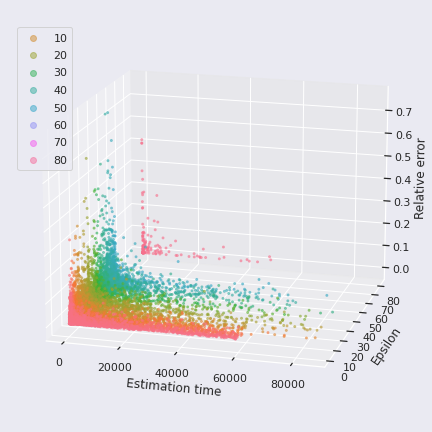

In [28]:
%matplotlib notebook
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
sc = ax.scatter(df.estimation_time, df.epsilon, df.rel_error, s=4, c=df.epsilon,
                marker='o', cmap=cmap, alpha=0.5)
ax.set_xlabel('Estimation time')
ax.set_ylabel('Epsilon')
ax.set_zlabel('Relative error')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(0.18, 0.95), loc=0)

In [30]:
df[(df.rel_error > 0) & (df.epsilon < 3)].sort_values(by="rel_error", ascending=False).drop(columns=["str_repr"])

,retries_per_sample,sample_size,sample_misses,sample_hits,miss_ratio,bruteforce,bruteforce_time,estimation,estimation_time,n_states,sparsity,string_len,epsilon,kappa_multiple,phi_multiple,rel_error
9279,245709,29,0,290,0.000000,64,0,86.1260,1,2,0.56,6,2.28,1,450,0.345719
10906,420798,432,0,17280,0.000000,128,0,102.0030,322,6,0.66,7,0.73,1,350,0.203102
10916,330937,108,124,4320,0.028704,128,0,104.8930,97,6,0.66,7,2.93,1,175,0.180523
9243,254084,33,97,330,0.293939,64,0,74.9217,3,2,0.56,6,2.05,1,125,0.170652
5847,290639,58,0,1508,0.000000,16,0,13.3621,6,6,0.96,6,2.93,1,350,0.164869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10398,456815,753,0,47439,0.000000,647,15,646.9790,478,7,0.88,12,1.02,1,500,0.000032
9156,460739,800,0,88800,0.000000,488,15,488.0130,1493,11,0.89,12,1.71,1,300,0.000027
5877,494126,1339,19,137917,0.000138,7936,217,7936.1900,6045,10,0.90,13,1.02,1,250,0.000024
104,594950,6343,0,926078,0.000000,4096,175,4096.0800,59010,13,0.54,12,0.28,1,450,0.000020


In [40]:
%%time
probe = df.loc[9279]
cpp_input_nfa = probe.str_repr
cpp_input_nfa = cpp_input_nfa[cpp_input_nfa.find("\n") :]
str_len = probe.string_len
ests = []
for phi in tqdm([25, 50, 75, 100, 125, 150, 175, 200, 250, 300, 350, 400, 450, 500]):
    eps = round(100/phi, 5)
    cpp_input = f'{str_len} {eps} 1 {phi}\n{cpp_input_nfa}'
    for i in range(50):
        result = subprocess.run(["timeout", "300", "./cpp/main"], 
                                    stdout=subprocess.PIPE, 
                                    input=cpp_input,
                                    encoding="utf-8")
        res_dict2 = {}
        if result.returncode == 0:
            invalid = False
            for line in result.stdout.split("\n"):
                if "Got 0 when" in line or "Empty NFA" in line:
                    print(line)
                    invalid = True
                    break
                l_split = line.split()
                if len(l_split) == 2:
                    k, v = l_split
                    res_dict2[k] = float(v) if "." in v else int(v)
            if not invalid:
                res_dict2["epsilon"] = eps
                res_dict2["phi_multiple"] = phi
                ests.append(res_dict2)

100%|███████████████████████████████████████████| 14/14 [00:11<00:00,  1.19it/s]

CPU times: user 313 ms, sys: 2.68 s, total: 2.99 s
Wall time: 11.8 s


In [41]:
df_probe = pd.DataFrame(ests)

In [42]:
df_probe["rel_error"] = abs(df_probe.estimation - probe.bruteforce)/probe.bruteforce

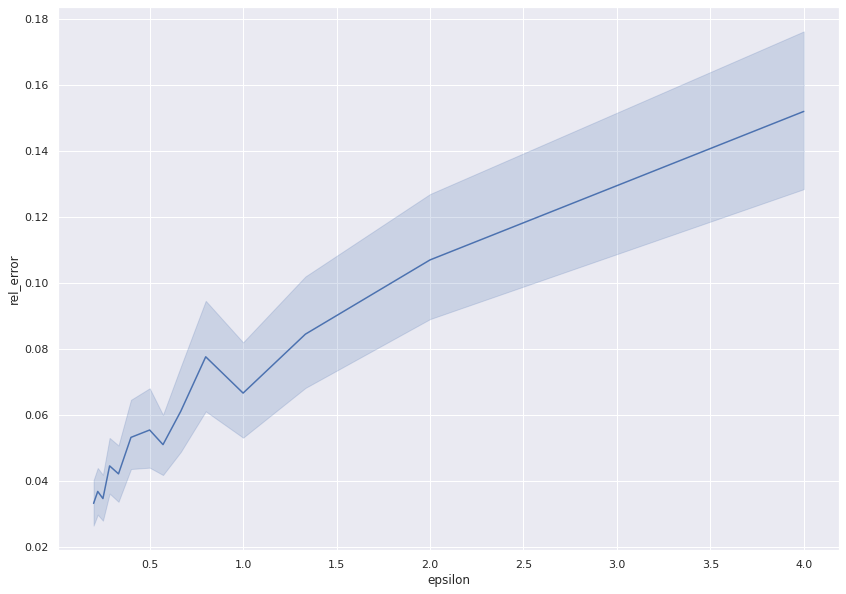

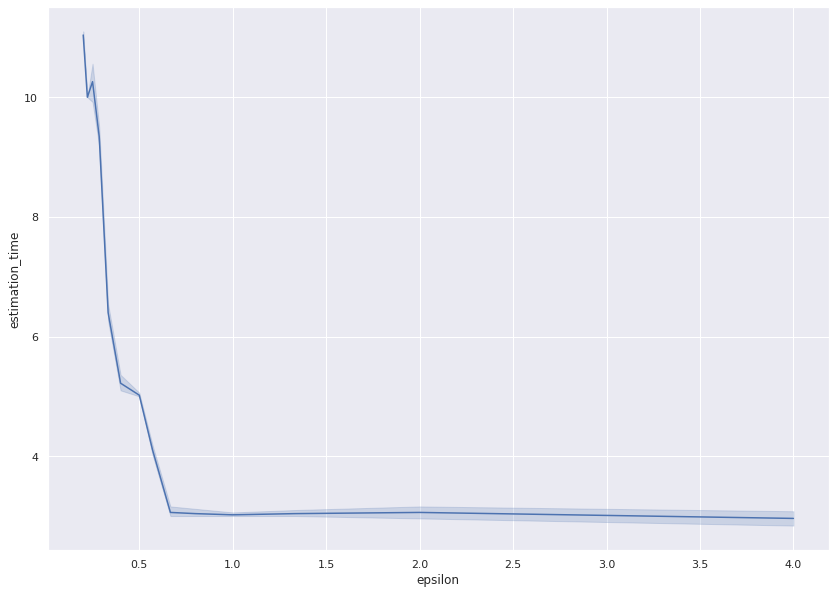

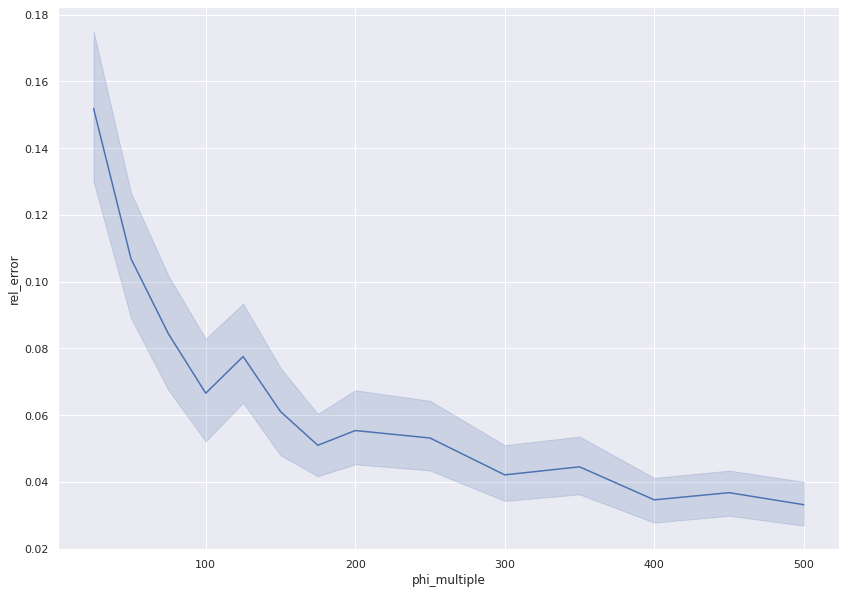

<AxesSubplot:xlabel='phi_multiple', ylabel='estimation_time'>

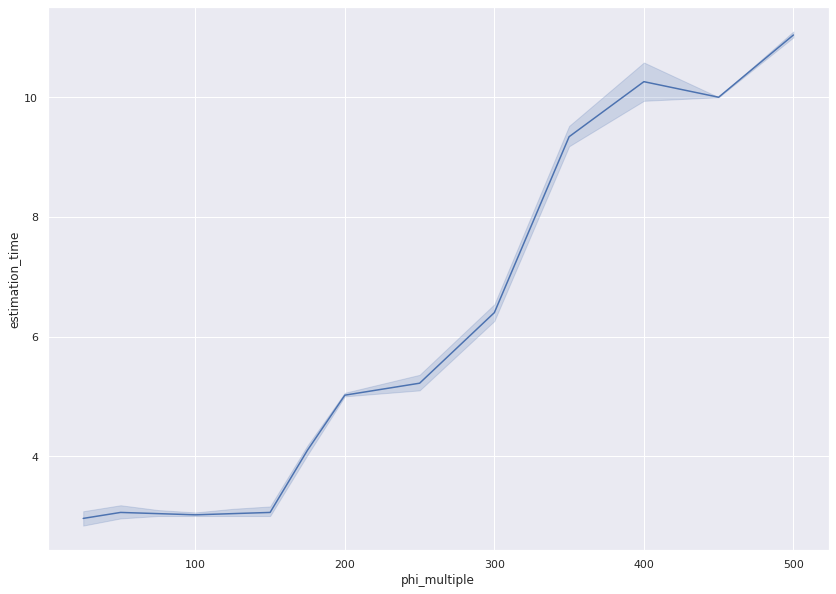

In [43]:
%matplotlib inline
sns.set(rc={"figure.figsize": (14,10)})
sns.lineplot(data=df_probe, x="epsilon", y="rel_error")
plt.show()
sns.lineplot(data=df_probe, x="epsilon", y="estimation_time")
plt.show()
sns.lineplot(data=df_probe, x="phi_multiple", y="rel_error")
plt.show()
sns.lineplot(data=df_probe, x="phi_multiple", y="estimation_time")

# Pentanacci NFA

In [86]:
rand_matrix = np.array(
   [[0, 0, 1, 0, 1, 0],
   [0, 0, 0, 0, 0, 0],
   [0, 1, 0, 1, 0, 0],
   [0, 1, 0, 0, 1, 0],
   [0, 0, 0, 0, 0, 0],
   [1, 1, 0, 1, 0, 0],
   [1, 0, 0, 0, 1, 0],
   [1, 0, 0, 0, 0, 1],
   [0, 1, 1, 1, 0, 0],
   [0, 0, 0, 0, 0, 0],
   [0, 1, 0, 1, 0, 1],
   [0, 0, 1, 0, 0, 0],
   [0, 0, 0, 1, 0, 1],
   [1, 0, 0, 0, 1, 0]])

array([[0, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0],
       [0, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 1, 0, 1, 0, 0],
       [1, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 1],
       [0, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 1],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 1],
       [1, 0, 0, 0, 1, 0]])

In [78]:
data = [rand_nfa.bruteforce_count_only(i) for i in range(26)]

In [81]:
[data[i+1] / data[i] for i in range(1, 25)]

[2.0,
 3.5,
 2.142857142857143,
 1.8666666666666667,
 2.0,
 1.9821428571428572,
 1.954954954954955,
 1.9631336405529953,
 1.9671361502347418,
 1.9665871121718377,
 1.9660194174757282,
 1.9657407407407408,
 1.965928717224054,
 1.9659771583739318,
 1.9659571010724732,
 1.965946191676654,
 1.9659449232709691,
 1.9659484602224122,
 1.965948802184324,
 1.9659483110412075,
 1.9659481587913195,
 1.9659481928633655,
 1.9659482494953409,
 1.9659482458453843]

In [82]:
data

[0,
 1,
 2,
 7,
 15,
 28,
 56,
 111,
 217,
 426,
 838,
 1648,
 3240,
 6369,
 12521,
 24616,
 48394,
 95140,
 187040,
 367711,
 722901,
 1421186,
 2793978,
 5492816,
 10798592,
 21229473]

In [85]:
print(rand_nfa.to_text())

6 2 20
0 1 2 3 4 5
0 0 0 1 0 1
1 0 0 0 1 0
0 1
0 0 4
0 0 2
0 1 4
0 1 0
1 1 5
1 1 0
2 0 1
2 0 3
2 1 2
2 1 1
2 1 3
3 0 4
3 0 1
4 1 5
4 1 1
4 1 3
5 0 0
5 0 1
5 0 3
5 1 2
